In [1]:
# user guide from https://pmelchior.github.io/scarlet/0-quickstart.html
from functools import partial
from itertools import product, starmap
from  typing import Callable, List, Tuple

# Import Packages and setup
import numpy as np
import scarlet
import scarlet.psf as psf
import scarlet.display
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin='lower')
plt.style.use("robertsons_rules")

In [2]:
data = np.load("hsc_cosmos_35.npz")
images = data["images"] # (5, 58, 48)
filters = data["filters"] # ['g', 'r', 'i', 'z', 'y']
catalog = data["catalog"] # List of 2-Tuple, x and y
weights = 1/data["variance"] # (5, 58, 48)
psfs = scarlet.ImagePSF(data["psfs"]) # (5, 43, 43)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


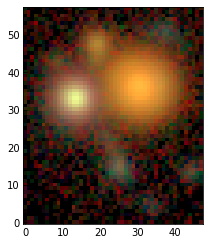

In [3]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [4]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psfs=psfs,
    weights=weights,
    channels=filters).match(model_frame)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


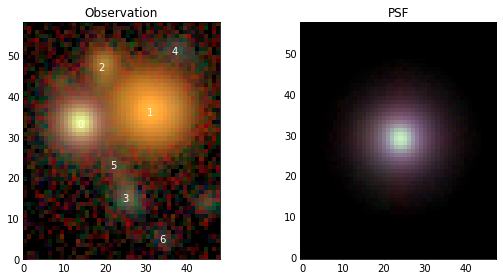

In [5]:
sky_coords = [[src['y'], src['x']] for src in catalog] # y/x!
scarlet.display.show_observation(observation, norm=norm, sky_coords=sky_coords, show_psf=True)
plt.show()

In [6]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    elif k == 1:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, K=2)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, compact=True)
    sources.append(new_source)

CPU times: user 2.65 s, sys: 22 ms, total: 2.67 s
Wall time: 2.75 s
scarlet ran for 76 iterations to logL = 30420.93855546932


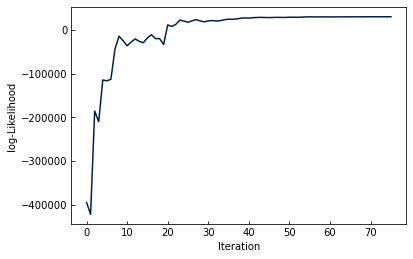

In [7]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

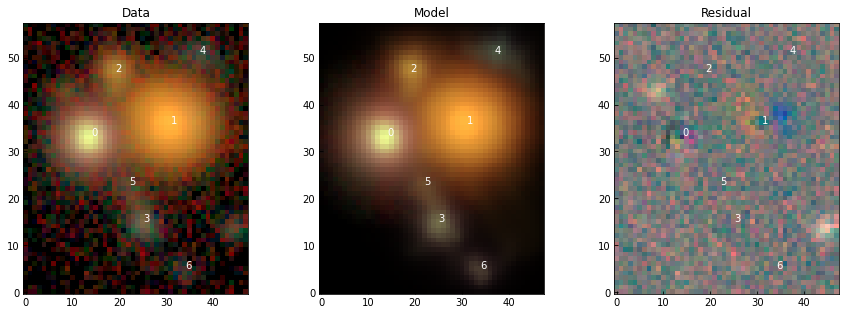

In [8]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# each source rendered in each band
model_vals = [observation.render(sources[i].get_model(frame=sources[i].frame)) for i in range(len(sources))]

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

### Morpheus Deblend Center of Mass

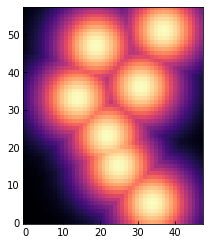

In [9]:
#https://stackoverflow.com/a/46892763/2691018
def gkern(kernlen=21, std=8):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def generate_com(shape:Tuple[int, int], srcs:List[np.ndarray]) -> np.ndarray:
    gk_len = 51
    gk = gkern(gk_len, 8)
    
    com = np.zeros(shape, dtype=np.float32)
    height, width = shape
    for src in catalog:
        y, x = int(src["y"]), int(src["x"])
        half_len = int((gk_len / 2))
        

        big_ys = slice(
            max(y-half_len, 0),
            min(y+half_len, height)
        )
        
        big_xs = slice(
            max(x-half_len, 0),
            min(x+half_len, height)
        )
        
        g_ys = slice(
            half_len - min(half_len, half_len-(half_len-y)),
            half_len + min(half_len, height-y),
        )
        
        g_xs = slice(
            half_len - min(half_len, half_len-(half_len-x)),
            half_len + min(half_len, width-x),
        )
        
        b = com[big_ys, big_xs].copy()
        g = gk[g_ys, g_xs].copy()

        com[big_ys, big_xs] = np.maximum(g, b)

    return com

plt.imshow(generate_com(images.shape[1:], catalog))

## Morpheus Label Claim Vector/Mapss

Encoder

In [10]:
neighborhood_vectors = np.array(list(product([0, -1, 1], [0, -1, 1]))[1:], dtype=np.float32)
neighborhood_vectors /= np.linalg.norm(neighborhood_vectors, axis=-1)[:, np.newaxis]

# Updates `claim_vector_magnitude` and `claim_map` in place
def get_claim_vector_magnitudes_single_pixel(claim_vector_magnitude, claim_map, model_vals, src_centers, y, x, b) -> None:
    relative_vectors = src_centers - np.array([y, x])
    src_fluxes = np.array([max(model_vals[i][b, y, x], 0) for i in range(len(model_vals))])
    normed_flux = src_fluxes / src_fluxes.sum()

    cosine_measure = cosine_similarity(neighborhood_vectors, relative_vectors)
    cosine_measure[:, src_fluxes < 0] = -1

    euclidean_distance = euclidean_distances(neighborhood_vectors, relative_vectors)
    normed_euclidean_distance = euclidean_distance / euclidean_distance.sum()

    metric = cosine_measure * (1 - normed_euclidean_distance) * (normed_flux[np.newaxis, :])
    #metric[metric<=0] = np.inf
    
    
    closest_srcs = np.argmax(metric, axis=1)
    selected_srcs = relative_vectors[closest_srcs, :]

    _claim_magnitudes = (selected_srcs * neighborhood_vectors).sum(axis=1)


    idxs, counts = np.unique(closest_srcs, return_counts=True)
    coefs = np.reciprocal(counts.astype(np.float32))
    _claim_map = np.array(list(map(lambda i: coefs[idxs==i][0] * normed_flux[i], closest_srcs)))    

    claim_vector_magnitude[y, x, b, :] = _claim_magnitudes
    claim_map[y, x, b, :] = _claim_map

def get_claim_vector_magnitude_map(model_vals, srcs_centers) -> Tuple[np.ndarray, np.ndarray]:
    b, y, x = model_vals[0].shape
    
    idxs = product(range(y), range(x), range(b))

    claim_vector_magnitude = np.zeros([y, x, b, 8], dtype=np.float32)
    claim_map = np.zeros([y, x, b, 8], dtype=np.float32)

    encode_f = partial(get_claim_vector_magnitudes_single_pixel, claim_vector_magnitude, claim_map, model_vals, src_centers)

    for _ in starmap(encode_f, tqdm(idxs, total=y*x*b)):
        pass

    return claim_vector_magnitude, claim_map

In [11]:
src_centers = np.array([[c["y"], c["x"]] for c in catalog]) + np.sqrt(2)
claim_vector_magnitude, claim_map = get_claim_vector_magnitude_map(model_vals, src_centers)

100%|██████████| 13920/13920 [00:15<00:00, 915.63it/s]


## Morpheus Label Claim Vectors

Decoder

In [12]:
neighborhood_vectors = np.array(list(product([0, -1, 1], [0, -1, 1]))[1:], dtype=np.float32)
neighborhood_vectors /= np.linalg.norm(neighborhood_vectors, axis=-1)[:, np.newaxis]

def decode_single_pixel(
    output:np.ndarray,
    flux:np.ndarray, 
    claim_vector_magnitude:np.ndarray, 
    claim_map:np.ndarray, 
    src_centers:np.ndarray, 
    y:int, 
    x:int, 
    b:int
) -> None:
    pixel_flux = flux[y, x, b]
    pixel_magnitudes = claim_vector_magnitude[y, x, b, :].copy()
    pixel_claim_map = claim_map[y, x, b, :].copy()

    relative_vectors = neighborhood_vectors * pixel_magnitudes[:, np.newaxis]
    relative_centers = src_centers - np.array([y, x])

    distances = euclidean_distances(relative_vectors, relative_centers) # [n_neighborhood, n_centers]
    closest_src = np.argmin(distances, axis=1)

    distributed_flux = pixel_flux * pixel_claim_map

    def update_output(src_idx:int, flx:float):
        output[src_idx, y, x, b] += flx

    for _ in starmap(update_output, zip(closest_src, distributed_flux)):
        pass

def decode(
    flux:np.ndarray, 
    claim_vector_magnitude:np.ndarray, 
    claim_map:np.ndarray, 
    src_centers:np.ndarray
) -> np.ndarray:
    y, x, b = flux.shape
    output = np.zeros([src_centers.shape[0], y, x, b], dtype=np.float32)

    idxs = product(range(y), range(x), range(b))

    decode_f = partial(decode_single_pixel, output, flux, claim_vector_magnitude, claim_map, src_centers)

    for _ in starmap(decode_f, tqdm(idxs, total=y*x*b)):
        pass

    return output

In [13]:
src_centers = np.array([[c["y"], c["x"]] for c in catalog]) + 0.5
claim_vector_magnitude, claim_map = get_claim_vector_magnitude_map(model_vals, src_centers)

flux = np.transpose(images, axes=(1,2,0))
output = decode(flux, claim_vector_magnitude, claim_map, src_centers)

100%|██████████| 13920/13920 [00:03<00:00, 3752.23it/s]


In [14]:
print(neighborhood_vectors)

[[ 0.         -1.        ]
 [ 0.          1.        ]
 [-1.          0.        ]
 [-0.70710677 -0.70710677]
 [-0.70710677  0.70710677]
 [ 1.          0.        ]
 [ 0.70710677 -0.70710677]
 [ 0.70710677  0.70710677]]


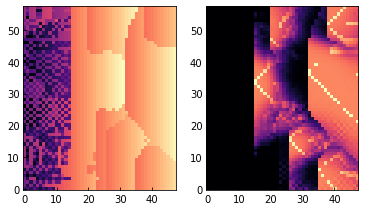

In [15]:
f, axes = plt.subplots(ncols=2)
b = 0
idx = 0

axes[0].imshow(claim_vector_magnitude[:, :, b, idx])
axes[1].imshow(claim_map[:, :, b, idx])

(0.0, 1.0, 0.0, 1.0)

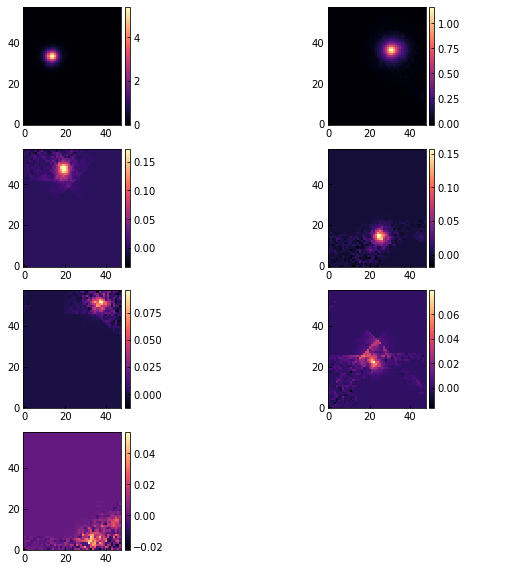

In [19]:
band = 0

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

(0.0, 1.0, 0.0, 1.0)

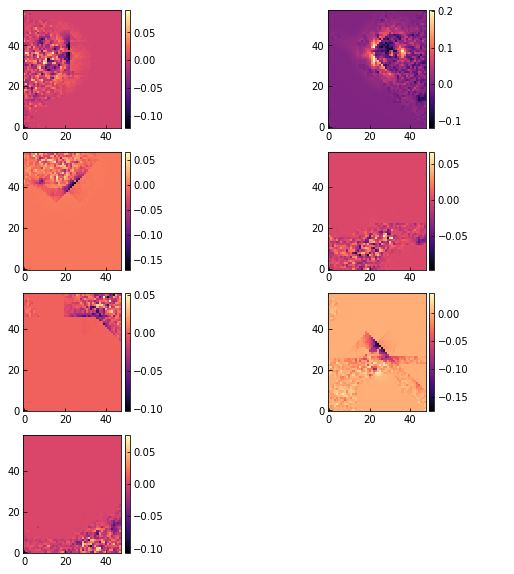

In [17]:
band = 3

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(model_vals[i][band, :, :] - output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

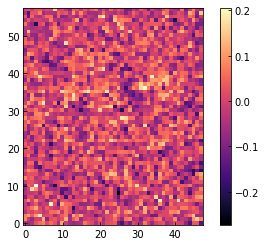

In [18]:
band = 4
plt.imshow(sum(model_vals)[band, :, :] - output.sum(axis=0)[:, :, band])
plt.colorbar()